In [42]:
import csv
import numpy as np
import utils
import hrr_utils
import time


from scipy import spatial
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

N=1000

def genX(verbs):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))

    for m, pair in enumerate(verbs):
        past1 = hrr_utils.GetRVClipHash(pair[1], dic1, 3)
        past2 = hrr_utils.GetRVClipHash(pair[1], dic2, 3)
        pres1 = hrr_utils.GetRVClipHash(pair[0], dic1, 3)
        pres2 = hrr_utils.GetRVClipHash(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2


def closed_train(Past, Present):
    return np.dot(np.linalg.pinv(Present), Past)

# HD Algo
def train(W, past, present):
    # col x row
    W += np.outer(present, past)
    return W

def train_diff(W, past2, present1, present2):
    W += np.outer(present1, past2-present2)
    return W

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def graph(x, y1, y2, title=None, xlabel='number of words', ylabel='average dot product', legend='upper right'):

    fig = plt.figure(figsize=(4,3))
    plt.plot(x, y1, label="train")
    plt.plot(x, y2, label="test")
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(loc=legend)
    plt.show()
    #fig.savefig('test.jpg')
    
def graphwstd(x, y1, y2, y1std, y2std, title=None, xlabel='number of words', ylabel='average dot product', legend='upper right'):
    """
    fig = plt.figure(figsize=(4,3))
    plt.plot(x, y1, label="train")
    plt.plot(x, y2, label="test")
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(loc=legend)
    plt.show()
    #fig.savefig('test.jpg')
    """
    
    fig = plt.figure(figsize=(4,3))
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend)

    plt.xlabel('Number Training Examples')
    plt.ylabel('Feature Similarity')
    plt.title(title)

    plt.xlim([0, 1700])

    plt.tight_layout()

In [2]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)

data_size = 100
reg_pres, reg_past, reg_freq = reg_pres[:data_size], reg_past[:data_size], reg_freq[:data_size]
irreg_pres, irreg_past, irreg_freq = irreg_pres[:data_size], irreg_past[:data_size], irreg_freq[:data_size]

regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

#train_cutoff = 1700
train_cutoff = 70

train_reg = regular[0:train_cutoff]
train_irreg = irregular[0:train_cutoff]


test_reg = regular[train_cutoff:]
test_irreg = irregular[train_cutoff:]

dic1 = hrr_utils.GenerateDefaultDictionary(N)
dic2 = hrr_utils.GenerateDefaultDictionary(N)

regular.extend(irregular)
verbs = regular

In [3]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_reg + train_irreg)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_reg + test_irreg)

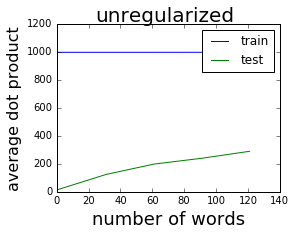

figures/unregularized_trigam_regression-N=1000-W=140-170405


In [28]:
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 30)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    W = closed_train(trainpast2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    
graph(x,y1,y2,title='unregularized',legend='upper right')

fname =  ('figures/unregularized_trigam_regression-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


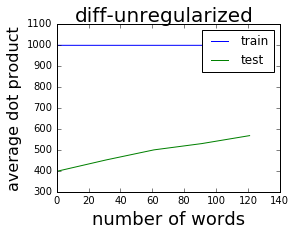

figures/diff_unregularized_trigam_regression-N=1000-W=140-170405


In [29]:
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 30)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    W = closed_train(trainpast2[:k]-trainpres2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(W) + trainpres2[:k]
    test_pred = testpres1.dot(W) + testpres2

    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    
graph(x,y1,y2,title='diff-unregularized',legend='upper right')

fname =  ('figures/diff_unregularized_trigam_regression-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

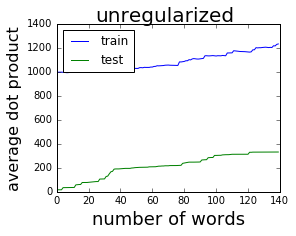

figures/unregularized_outer_trigam_dict-N=1000-W=140-170405


In [26]:
W = np.zeros((N,N))
W = train(W, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
for i in range(x.shape[0]):
    k = x[i]
    train_pred = W.T.dot(trainpres1[:k].T).T
    test_pred = W.T.dot(testpres1.T).T

    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()

    W = train(W, trainpast2[k], trainpres1[k])

graph(x,y1/N,y2/N,"unregularized", legend="upper left")

fname =  ('figures/unregularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

# change location/ add location parameter for legend

In [38]:
def reg_train(W, Past, Present):
    pred = W.T.dot(Present.T).T
    print sim(pred, Past)
    W += ((N*N-sim(pred, Past))/float(N*N)) * np.outer(Past, Present)
    return W

0.0
-168.0
1276.165984
-1119.27865241
2441.55823641
242.727247977
4812.85191572
-550.323367958
-3404.80646489
-2115.23858105
483.740434426
-3796.424945
-3709.01572768
-2964.92858533
3202.58297459
-5354.70335582
-416.641539256
-539.008287483
1040.90996644
-8202.48594327
-294.475728531
2619.31390928
4321.85043726
4117.60079274
-1144.71319306
2161.52221373
-11364.5326648
662.513889658
-12382.0222563
510.992915808
180.140412737
-1951.43569773
-2194.1389022
4864.67532574
8023.44039974
-4833.53761179
-23969.9533349
727.480658674
5247.06618079
1909.75917774
-12762.6112425
10963.1499217
1428.81366476
1543.82031392
4.60910673886
746.910239723
10560.325475
4539.54322805
9503.70125881
12670.2747555
8949.15743319
-2637.02980124
-2891.61992698
4094.79351855
14030.6613574
-1319.83265029
-325.832784344
8638.7951308
2747.61720913
-10685.6330102
3015.59477561
-4113.57571419
13755.7606123
-16317.5245911
-1318.88751377
8518.66385035
13407.9851631
-4537.9950694
9694.37672048
-10272.9113335
-4419.60293354


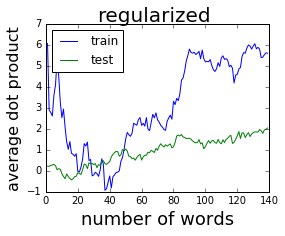

figures/regularized_outer_trigam_dict-N=1000-W=140-170405


In [39]:
W = np.zeros((N,N))
W = reg_train(W, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

for i in range(x.shape[0]):
    k = x[i]
    train_pred = W.T.dot(trainpres1[:k].T).T
    test_pred = W.T.dot(testpres1.T).T
    
    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    
    W = reg_train(W, trainpast2[k], trainpres1[k])

graph(x,y1/N,y2/N,title='regularized', legend='upper left')

fname =  ('figures/regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

# change location/ add location parameter for legend

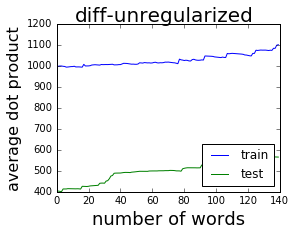

figures/diff_unregularized_outer_trigam_dict-N=1000-W=140-170405


In [58]:
W = np.zeros((N,N))
W = train_diff(W, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    train_pred = trainpres1[:k].dot(W)
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = testpres1.dot(W)
    #test_pred = np.where(test_pred>0, 1, -1)
    
    train_pred = W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    test_pred = W.T.dot(testpres1.T).T + testpres2*N
    
    y1[i] = sim(train_pred/float(N), trainpast2[:k]).mean()
    y2[i] = sim(test_pred/float(N), testpast2).mean()
    
    W = train_diff(W, trainpast2[k], trainpres1[k], trainpres2[k])

graph(x,y1,y2,title='diff-unregularized', legend='lower right')

fname =  ('figures/diff_unregularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [54]:
def reg_train_diff(W, past2, present1, present2):
    #pred = (W.T.dot(present1.T).T + present2*N)/float(N)
    pred = W.T.dot(present1.T).T + present2*N
    return ((N*N-sim(pred, past2))/float(N*N)) * np.outer(present1, past2-present2)

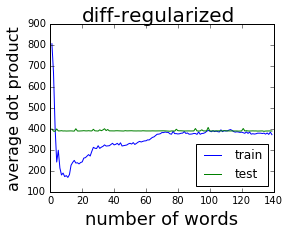

figures/diff_regularized_outer_trigam_dict-N=1000-W=140-170405


In [60]:
W = np.zeros((N,N))
W = reg_train_diff(W, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    train_pred = trainpres1[:k].dot(W)
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = testpres1.dot(W)
    #test_pred = np.where(test_pred>0, 1, -1)
    
    train_pred = W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    test_pred = W.T.dot(testpres1.T).T + testpres2*N
    
    y1[i] = sim(train_pred/float(N), trainpast2[:k]).mean()
    y2[i] = sim(test_pred/float(N), testpast2).mean()
    
    W = reg_train_diff(W, trainpast2[k], trainpres1[k], trainpres2[k])

graph(x,y1,y2,title='diff-regularized', legend='lower right')

fname =  ('figures/diff_regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [ ]:
# STILL TRYING TO GRAPH STANDARD DEVIATIONS

figures/unregularized_trigam_regression-N=1000-W=140-170405


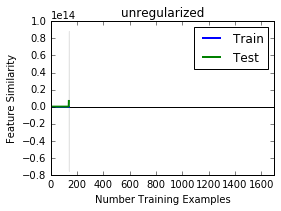

In [62]:
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    W = closed_train(trainpast2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)

    y1[i] = sim1.mean()
    y1std[i] = np.nanstd(sim1, axis=0) #/ (arange(len(train_mean))+1) ** 0.5
    y2[i] = sim2.mean()
    y2std[i] = sim2.std(axis=0) #/ testpast2.shape[0]**0.5
    
graphwstd(x,y1,y2,y1std,y2std,title='unregularized',legend='upper right')

fname =  ('figures/unregularized_trigam_regression-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [63]:
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(trainpres1.shape[0])
y2std = np.zeros(trainpres1.shape[0])

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    W = closed_train(trainpast2[:k]-trainpres2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(W) + trainpres2[:k]
    test_pred = testpres1.dot(W) + testpres2

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    y1[k] = sim1.mean()
    y1std[k] = np.nanstd(sim1, axis=0) #/ (arange(len(train_mean))+1) ** 0.5
    y2[k] = sim2.mean()
    y2std[k] = sim2.std(axis=0) #/ testpast2.shape[0]**0.5
    
graphwstd(x,y1/N,y2/N,y1std/N,y2std/N,title='diff-unregularized',legend='upper right')

fname =  ('figures/diff_unregularized_trigam_regression-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

IndexError: index 139 is out of bounds for axis 0 with size 139

In [13]:
random_vec = np.random.randn(N)
W = np.zeros((N,N))


temp = np.outer(trainpres1[0], trainpast2[0])
temp1 = np.outer(trainpast2[0], trainpres1[0])
print np.array_equal(temp1, temp) # so order matters

print np.array_equal(np.matrix([[0,0],[0,0]]), np.matrix([[0,0],[0,0]]))

W += temp
p = W.dot(trainpres1[0])
p1 = W.dot(trainpres1[0].T)
p2 = W.T.dot(trainpres1[0])
p3 = W.T.dot(trainpres1[0].T)


p3 = W.dot(trainpres1[0])
p4 = W.dot(trainpres1[0])
p5 = W.dot(trainpres1[0])
p6 = W.dot(trainpres1[0])
p7 = W.dot(trainpres1[0])

s = sim(p, trainpast2[0]).mean()
s1 = sim(p1, trainpast2[0]).mean()
s2 = sim(p2, trainpast2[0]).mean()
s3 = sim(p3, trainpast2[0]).mean()

print (s, s1, s2, s3)

False
True
(17956.0, 17956.0, 1000000.0, 17956.0)


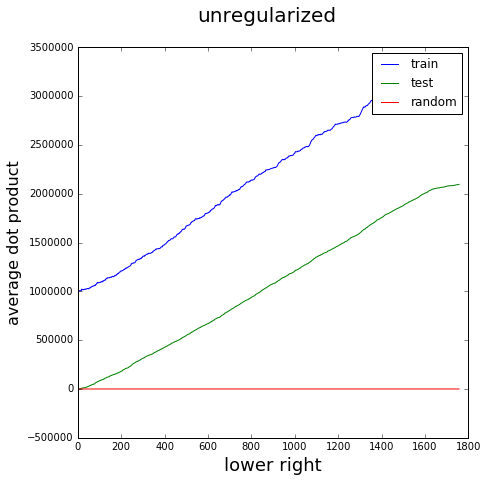

figures/unregularized_outer_trigam_dict-N=1000-W=1758-170322


In [15]:
W = np.zeros((N,N))
W = train(W, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(trainpres1.shape[0])
y2std = np.zeros(trainpres1.shape[0])

for i in range(x.shape[0]):
    k = x[i]
    train_pred = W.T.dot(trainpres1[:k].T).T/float(N)
    test_pred = W.T.dot(testpres1.T).T/float(N)
    
    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    y1[k] = sim1.mean()
    y1std[k] = np.nanstd(sim1, axis=0) #/ (arange(len(train_mean))+1) ** 0.5
    y2[k] = sim2.mean()
    y2std[k] = sim2.std(axis=0) #/ testpast2.shape[0]**0.5
    
    W = train(W, trainpast2[k], trainpres1[k])

graph(x,y1/(N*N),y2/(N*N),y1std/(N*N),y2std/(N*N),title='unregularized', legend='lower right')

fname =  ('figures/unregularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


In [ ]:
W = np.zeros((N,N))
W = reg_train(W, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(trainpres1.shape[0])
y2std = np.zeros(trainpres1.shape[0])

for i in range(x.shape[0]):
    k = x[i]
    train_pred = W.T.dot(trainpres1[:k].T).T
    test_pred = W.T.dot(testpres1.T).T
    
    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    y1[k] = sim1.mean()
    y1std[k] = np.nanstd(sim1, axis=0) #/ (arange(len(train_mean))+1) ** 0.5
    y2[k] = sim2.mean()
    y2std[k] = sim2.std(axis=0) #/ testpast2.shape[0]**0.5
    
    W = reg_train(W, trainpast2[k], trainpres1[k])

graph(x,y1/(N*N),y2/(N*N),y1std/(N*N),y2std/(N*N),title='unregularized', legend='lower right')

fname =  ('figures/regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

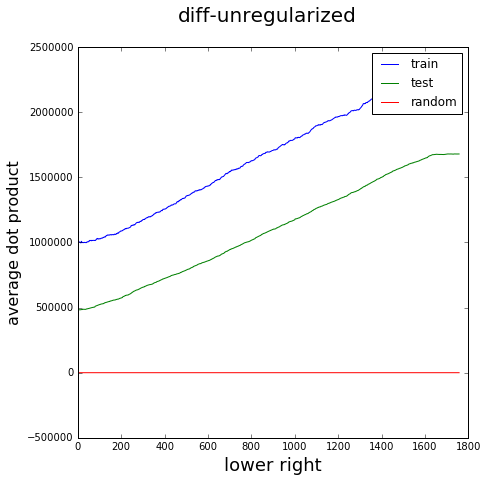

figures/diff_unregularized_outer_trigam_dict-N=1000-W=1758-170322


In [16]:
W = np.zeros((N,N))
W = train_diff(W, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(trainpres1.shape[0])
y2std = np.zeros(trainpres1.shape[0])

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    train_pred = trainpres1[:k].dot(W)
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = testpres1.dot(W)
    #test_pred = np.where(test_pred>0, 1, -1)
    
    train_pred = W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    test_pred = W.T.dot(testpres1.T).T + testpres2*N
    
    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    y1[k] = sim1.mean()
    y1std[k] = np.nanstd(sim1, axis=0) #/ (arange(len(train_mean))+1) ** 0.5
    y2[k] = sim2.mean()
    y2std[k] = sim2.std(axis=0) #/ testpast2.shape[0]**0.5
    
    W = train_diff(W, trainpast2[k], trainpres1[k], trainpres2[k])

graph(x,y1/(N*N),y2/(N*N),y1std/(N*N),y2std/(N*N),title='diff-unregularized', legend='lower right')

fname =  ('figures/diff_unregularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [ ]:
W = np.zeros((N,N))
W = train_diff(W, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(trainpres1.shape[0])
y2std = np.zeros(trainpres1.shape[0])

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    train_pred = trainpres1[:k].dot(W)
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = testpres1.dot(W)
    #test_pred = np.where(test_pred>0, 1, -1)
    
    train_pred = W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    test_pred = W.T.dot(testpres1.T).T + testpres2*N
    
    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    y1[k] = sim1.mean()
    y1std[k] = np.nanstd(sim1, axis=0) #/ (arange(len(train_mean))+1) ** 0.5
    y2[k] = sim2.mean()
    y2std[k] = sim2.std(axis=0) #/ testpast2.shape[0]**0.5
    
    W = train_diff(W, trainpast2[k], trainpres1[k], trainpres2[k])

graph(x,y1/(N*N),y2/(N*N),y1std/(N*N),y2std/(N*N),title='diff-unregularized', legend='lower right')

fname =  ('figures/diff_regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)